In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%tensorflow_version 1.x
#输出TensorFlow 1.x selected.

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [ ]:
tf.__version__

'1.15.2'

In [ ]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# #download the model to local so it can be used again and again
# !mkdir module/module_elmo2
# # Download the module, and uncompress it to the destination folder. 
# !curl -L "https://tfhub.dev/google/elmo/2?tf-hub-format=compressed" | tar -zxvC module/module_elmo2

In [ ]:
train = pd.read_csv("/content/drive/My Drive/NLP/Elmo/Cleand_data/Train_elmo.csv", nrows= 5000)
test = pd.read_csv("/content/drive/My Drive/NLP/Elmo/Cleand_data/Test_elmo.csv",nrows=500)
train.shape,test.shape

((5000, 2), (500, 2))

In [ ]:
train.head()

,label,cleand
0,0,grow b 1965 watch loving thunderbird mate scho...
1,0,put movie dvd player sit coke chip expectation...
2,0,people know particular time past like feel ne ...
3,0,even though great interest biblical movie bore...
4,1,-PRON- be die hard dad army fan nothing ever c...


In [ ]:
# second round cleaning
# get rid of the ''
train['cleand'] = train['cleand'].str.replace("'"," ")
test['cleand'] = test['cleand'].str.replace("'"," ")
train['cleand'] = train['cleand'].str.replace("-PRON-"," ")
test['cleand'] = test['cleand'].str.replace("-PRON-"," ")
train['cleand'] = train['cleand'].str.replace("  "," ")
test['cleand'] = test['cleand'].str.replace("  "," ")
train['cleand'] = train['cleand'].str.replace("   "," ")
test['cleand'] = test['cleand'].str.replace("   "," ")

In [ ]:
train.cleand.iloc[0]

'grow b 1965 watch loving thunderbird mate school watch play thunderbird school lunch school want virgil scott one want alan count 5 become art form take child see movie hoping would get glimpse love child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife create jonatha frak hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment'

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [ ]:
# just a random sentence
x = ["Roasted ants are a popular snack in Columbia"]
# Extract ELMo features
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(1), Dimension(8), Dimension(1024)])

In [ ]:
X = np.array(train["cleand"])
y = np.array(train["label"])

In [ ]:
from collections import Counter
Counter(y)

Counter({0: 2582, 1: 2418})

In [ ]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [ ]:
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    # dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    dense = Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    # lstm = LSTM(64,input_shape=(None,64))(embedding)
    pred = Dense(1, activation='sigmoid')(lstm)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

In [ ]:
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ValueError: ignored

In [ ]:
model_elmo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 262,657
Trainable params: 262,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X, y, epochs=10, batch_size=16, validation_split = 0.2)
    model_elmo.save_weights('/content/drive/My Drive/NLP/Elmo/saved_weights/model_elmo_weights_10e.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 813s 102ms/sample - loss: 0.7222 - acc: 0.6886 - val_loss: 0.5785 - val_acc: 0.7375
Epoch 2/10
8000/8000 [==============================] - 679s 85ms/sample - loss: 0.5989 - acc: 0.7335 - val_loss: 0.5197 - val_acc: 0.7785
Epoch 3/10
8000/8000 [==============================] - 668s 83ms/sample - loss: 0.5486 - acc: 0.7659 - val_loss: 0.5629 - val_acc: 0.7370
Epoch 4/10
8000/8000 [==============================] - 670s 84ms/sample - loss: 0.5303 - acc: 0.7695 - val_loss: 0.5697 - val_acc: 0.7545
Epoch 5/10
8000/8000 [==============================] - 667s 83ms/sample - loss: 0.5136 - acc: 0.7744 - val_loss: 0.5727 - val_acc: 0.7250
Epoch 6/10
8000/8000 [==============================] - 664s 83ms/sample - loss: 0.4948 - acc: 0.7886 - val_loss: 0.4908 - val_acc: 0.7890
Epoch 7/10
8000/8000 [==============================] - 670s 84ms/sample - loss: 0.4843 - acc: 0.7935 - val_loss: 0.4

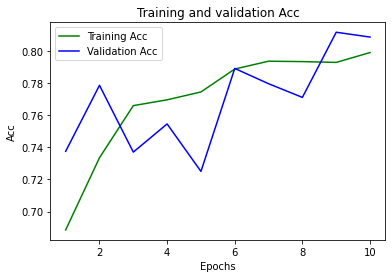

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [ ]:
test.head()

,label,cleand
0,0,always write series complete stinkf jim belush...
1,0,1st watch 1272002 3 10dirsteve purcell typica...
2,0,movie poorly write direct fall asleep 30 minut...
3,1,interesting thing miryang secret sunshine acto...
4,0,first read berlin meer expect much think right...


In [ ]:
X_test = np.array(test["cleand"])
y_test = np.array(test["label"])

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo = build_model() 
    model_elmo.load_weights('/content/drive/My Drive/NLP/Elmo/saved_weights/model_elmo_weights_10e.h5')
    import time
    t = time.time()
    # predicts = model_elmo.predict(X_test)
    print("Evaluate on test data")
    results = model_elmo.evaluate(X_test, y_test, batch_size=32)
    print("test loss, test acc:", results)
    print("time: ", time.time() - t)
    print(predicts)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Evaluate on test data
1000/1000 [==============================] - 76s 76ms/sample - loss: 0.4598 - acc: 0.8100
test loss, test acc: [0.4597593550682068, 0.81]
time:  76.19372320175171


NameError: ignored